In [1]:
from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.metrics import error_rate, accuracy
from torchvision.transforms import RandAugment
from torchvision.models.efficientnet import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import os
import timm
import seaborn as sns
import cv2
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
base_path = Path("/kaggle/input/dsc-logika-ui-2025")
train_path = base_path/'Train'/'Train'
test_path = base_path/'Test'/'Test'

base_path.ls()

(#3) [Path('/kaggle/input/dsc-logika-ui-2025/sample_submission.csv'),Path('/kaggle/input/dsc-logika-ui-2025/Test'),Path('/kaggle/input/dsc-logika-ui-2025/Train')]

In [3]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

aug = A.Compose
(
    [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.0625,
            scale_limit=0.1,
            rotate_limit=15,
            p=0.7
        ),
        A.RandomBrightnessContrast(p=0.8),
        A.HueSaturationValue(
            hue_shift_limit=10,
            sat_shift_limit=20,
            val_shift_limit=10,
            p=0.5
        ),
        A.CoarseDropout(
            max_holes=8,
            max_height=25,
            max_width=25,
            p=0.5
        )
    ]
)

dls_small = ImageDataLoaders.from_folder(
    train_path,
    valid_pct = 0.2,
    seed = 42,
    loss_func = LabelSmoothingCrossEntropy(),
    item_tfms = RandomResizedCrop(128, min_scale=0.75),
    batch_tfms = AlbumentationsTransform(aug)
)

dls_large = ImageDataLoaders.from_folder(
    train_path,
    valid_pct = 0.2,
    seed = 42,
    loss_func = LabelSmoothingCrossEntropy(),
    item_tfms = RandomResizedCrop(224, min_scale=0.75),
    batch_tfms = AlbumentationsTransform(aug)
)

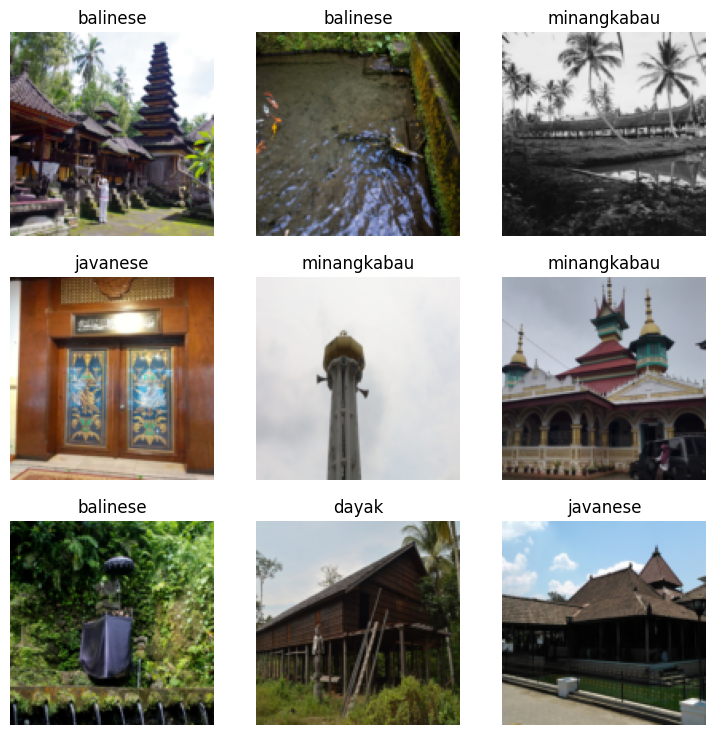

In [4]:
dls_small.show_batch(max_n=9)

In [5]:
test_files = get_image_files(test_path)
test_dl = dls_large.test_dl(test_files)

print("Classes:", dls_large.vocab)
print("Number of classes:", len(dls_large.vocab))
print("Number of training images:", len(dls_large.train_ds))
print("Number of validation images:", len(dls_large.valid_ds))

Classes: ['balinese', 'batak', 'dayak', 'javanese', 'minangkabau']
Number of classes: 5
Number of training images: 1402
Number of validation images: 350


In [6]:
model = timm.create_model('convnext_tiny.fb_in1k', pretrained=True)

learn = vision_learner(
    dls_small,
    'convnext_tiny.fb_in1k',
    metrics = F1Score(average='macro'),
    path = '/kaggle/working/'
)

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

0.00831763744354248

0.005248074419796467

0.0008317637839354575

0.0014454397605732083

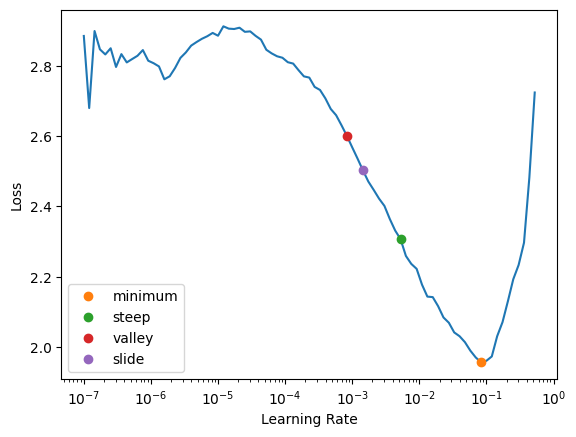

In [7]:
lrs_small = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
display(
    lrs_small.minimum,
    lrs_small.steep,
    lrs_small.valley,
    lrs_small.slide
)

In [8]:
learn.fit_one_cycle(
    15, 
    lrs_small.valley,
    cbs = [
        MixUp(0.6), 
        SaveModelCallback(monitor='f1_score')
    ]
)

epoch,train_loss,valid_loss,f1_score,time
0,2.648241,1.706083,0.273461,03:45
1,2.352127,1.224726,0.434902,03:42
2,2.085748,1.149762,0.510973,03:44
3,1.855124,1.062701,0.528906,03:43
4,1.659826,1.010990,0.534661,03:44
5,1.537896,0.934593,0.538946,03:42
6,1.417835,0.910109,0.552447,03:41
7,1.321190,0.913892,0.542874,03:45
8,1.237231,0.872533,0.545730,03:45
9,1.175821,0.834738,0.597348,03:42


Better model found at epoch 0 with f1_score value: 0.27346110803763013.
Better model found at epoch 1 with f1_score value: 0.43490186033680517.
Better model found at epoch 2 with f1_score value: 0.5109734007715047.
Better model found at epoch 3 with f1_score value: 0.5289063598750593.
Better model found at epoch 4 with f1_score value: 0.5346612425988988.
Better model found at epoch 5 with f1_score value: 0.5389460917573237.
Better model found at epoch 6 with f1_score value: 0.5524469470548002.
Better model found at epoch 9 with f1_score value: 0.5973483279253566.
Better model found at epoch 10 with f1_score value: 0.6022561994655018.
Better model found at epoch 11 with f1_score value: 0.629240941125464.
Better model found at epoch 13 with f1_score value: 0.6455896642751376.


0.001096478197723627

7.585775847473997e-07

0.0014454397605732083

0.0020892962347716093

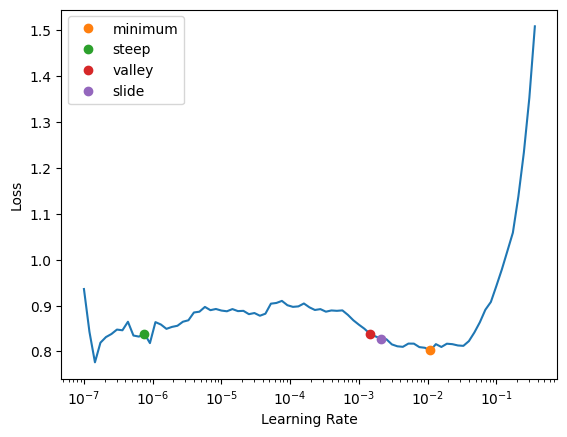

In [9]:
learn.dls = dls_large
lrs_large = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
display(
    lrs_large.minimum,
    lrs_large.steep,
    lrs_large.valley,
    lrs_large.slide
)

In [10]:
learn.unfreeze()

learn.fit_one_cycle(
    40,
    lrs_large.valley,
    cbs = [
        MixUp(0.6), 
        SaveModelCallback(monitor='f1_score')
    ]
)

epoch,train_loss,valid_loss,f1_score,time
0,1.125524,0.785518,0.574520,10:32
1,1.089375,0.757435,0.636256,10:25
2,1.048474,0.728033,0.608935,10:02
3,1.020228,0.722497,0.711335,10:13
4,0.998580,0.737709,0.681763,09:50
5,1.000264,0.978595,0.518186,09:57
6,1.007040,0.830426,0.548769,09:58
7,0.986014,0.778904,0.612956,10:05
8,0.961575,0.761881,0.621712,09:59
9,0.932046,0.872126,0.513335,09:58


Better model found at epoch 0 with f1_score value: 0.5745199501927845.
Better model found at epoch 1 with f1_score value: 0.6362564454789095.
Better model found at epoch 3 with f1_score value: 0.7113354084753167.
Better model found at epoch 12 with f1_score value: 0.711701808940908.
Better model found at epoch 16 with f1_score value: 0.7137062041671516.
Better model found at epoch 17 with f1_score value: 0.7333569794924804.
Better model found at epoch 18 with f1_score value: 0.7586083813554003.
Better model found at epoch 26 with f1_score value: 0.7951710633361989.


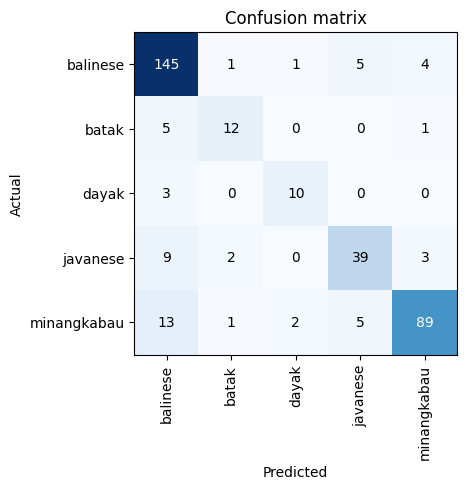

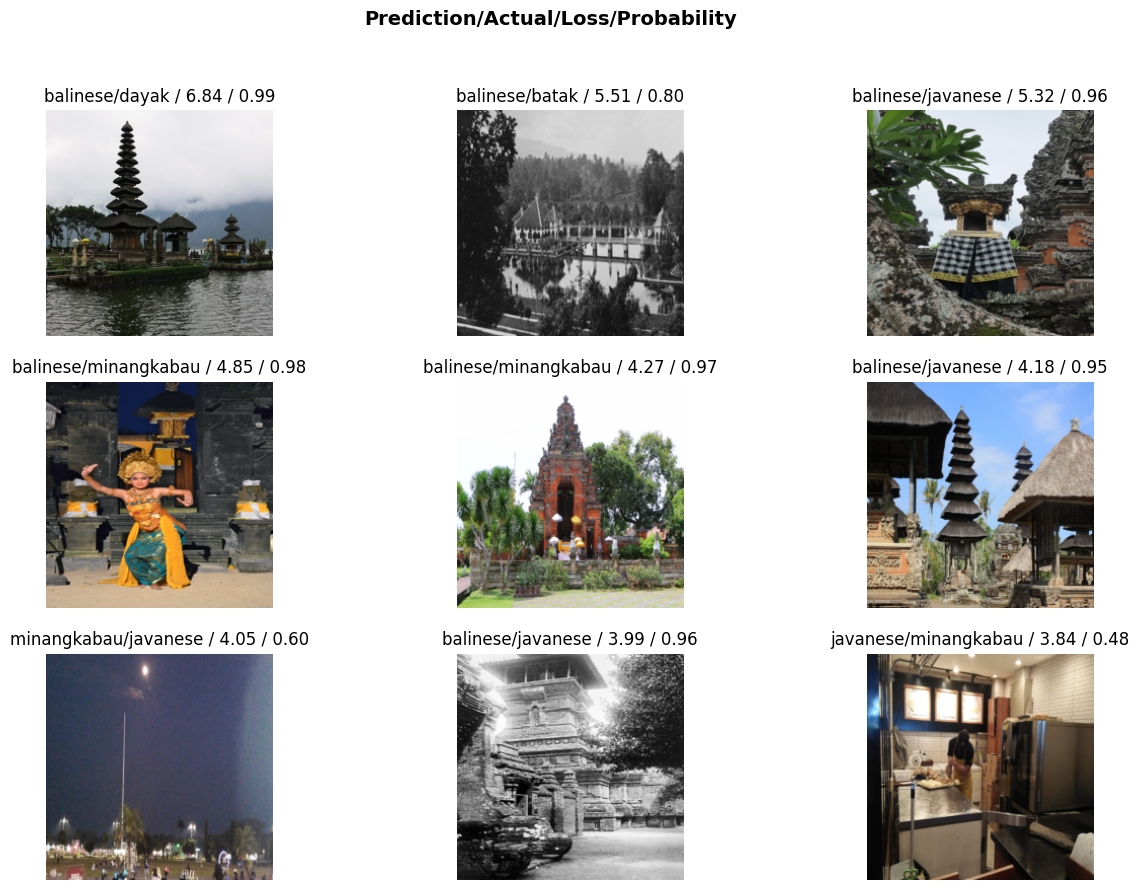

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(9, figsize=(15,10))

In [12]:
interp.print_classification_report()

              precision    recall  f1-score   support

    balinese       0.83      0.93      0.88       156
       batak       0.75      0.67      0.71        18
       dayak       0.77      0.77      0.77        13
    javanese       0.80      0.74      0.76        53
 minangkabau       0.92      0.81      0.86       110

    accuracy                           0.84       350
   macro avg       0.81      0.78      0.80       350
weighted avg       0.85      0.84      0.84       350



In [13]:
nama_file_model = 'klasifikasi-rumah-adat-v1.pkl'
learn.export(nama_file_model)

print(f"Model berhasil disimpan sebagai '{nama_file_model}'!")

Model berhasil disimpan sebagai 'klasifikasi-rumah-adat-v1.pkl'!


In [14]:
test_files = get_image_files(test_path)
preds, _ = learn.get_preds(dl=dls_large.test_dl(test_files))
pred_labels = preds.argmax(dim=1)
label_names = [dls_large.vocab[i] for i in pred_labels]

In [15]:
# Prepare submission DataFrame with correct columns: 'id' and 'style'
submission_get_preds = pd.DataFrame({
    'id': [f.name[:-4] for f in test_files],
    'style': label_names
})

# Ensure the order matches sample_submission.csv
sample_sub_path = train_path/'sample_submission.csv'
if sample_sub_path.exists():
    sample_sub = pd.read_csv(sample_sub_path)
    submission_get_preds = submission_get_preds.set_index('id').loc[sample_sub['id']].reset_index()

submission_get_preds.sort_values('id', inplace = True)
submission_get_preds['style'].value_counts()

style
balinese       222
minangkabau    131
javanese        63
batak           22
dayak            6
Name: count, dtype: int64

In [16]:
# Save to CSV
submission_get_preds.to_csv('submission_get_preds.csv', index=False)
print("Submission file saved as submission_get_preds.csv")

Submission file saved as submission_get_preds.csv


In [17]:
test_dl = dls_large.test_dl(test_files)
preds, _ = learn.tta(dl=test_dl)
pred_labels = preds.argmax(dim=1)
label_names = [dls_large.vocab[i] for i in pred_labels]

In [18]:
# Prepare submission DataFrame with correct columns: 'id' and 'style'
submission_tta = pd.DataFrame({
    'id': [f.name[:-4] for f in test_files],
    'style': label_names
})

# Ensure the order matches sample_submission.csv
sample_sub_path = train_path/'sample_submission.csv'
if sample_sub_path.exists():
    sample_sub = pd.read_csv(sample_sub_path)
    submission_tta = submission_tta.set_index('id').loc[sample_sub['id']].reset_index()

submission_tta.sort_values('id', inplace = True)
submission_tta['style'].value_counts()

style
balinese       221
minangkabau    130
javanese        63
batak           23
dayak            7
Name: count, dtype: int64

In [19]:
# Save to CSV
submission_tta.to_csv('submission_tta.csv', index=False)
print("Submission file saved as submission_tta.csv")

Submission file saved as submission_tta.csv
